##  Modeling

### 1. Import packages and load the data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer, make_column_transformer

In [2]:
jobs = pd.read_csv('data/jobs_data_step4_features.csv')
print(jobs.info())
print('There are {} observations and {} features in this dataset.'.format(jobs.shape[0],jobs.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             1960 non-null   float64
 1   Location           2047 non-null   object 
 2   Type of ownership  2037 non-null   object 
 3   Sector             1891 non-null   object 
 4   Revenue            1471 non-null   object 
 5   Years Founded      2047 non-null   float64
 6   Min_Salary         2047 non-null   int64  
 7   Max_Salary         2047 non-null   int64  
 8   Seniority          2047 non-null   object 
 9   HQ_Same            2047 non-null   int64  
 10  SQL                2047 non-null   int64  
 11  Excel              2047 non-null   int64  
 12  Python             2047 non-null   int64  
 13  Tableau            2047 non-null   int64  
 14  R                  2047 non-null   int64  
 15  SAS                2047 non-null   int64  
dtypes: float64(2), int64(9),

In [3]:
jobs.head()

,Rating,Location,Type of ownership,Sector,Revenue,Years Founded,Min_Salary,Max_Salary,Seniority,HQ_Same,SQL,Excel,Python,Tableau,R,SAS
0,3.2,NY,Nonprofit Organization,Non-Profit,$100 to $500 million (USD),59.0,37,66,Not specified,1,1,0,1,0,1,0
1,3.8,NY,Nonprofit Organization,Health Care,$2 to $5 billion (USD),127.0,37,66,Not specified,1,1,1,0,0,1,1
2,3.4,NY,Company - Private,Information Technology,NaN,17.0,37,66,Senior,1,1,1,0,1,0,0
3,4.1,NY,Subsidiary or Business Segment,Information Technology,$50 to $100 million (USD),18.0,37,66,Not specified,0,1,0,0,1,0,0
4,3.9,NY,Company - Private,"Arts, Entertainment & Recreation",$100 to $500 million (USD),11.0,37,66,Not specified,1,1,1,1,0,0,0


### 2.Train/Test Split

In [4]:
# Split data to predict Min_Salary
X_train, X_test, y_train1, y_test1 = train_test_split(jobs.drop(columns=['Min_Salary','Max_Salary']), 
                                                    jobs.Min_Salary, test_size=0.3, random_state=47)
# Split data to predict Max_Salary
X_train, X_test, y_train2, y_test2 = train_test_split(jobs.drop(columns=['Min_Salary','Max_Salary']), 
                                                    jobs.Max_Salary, test_size=0.3, random_state=47)

In [5]:
X_train.shape, X_test.shape

((1432, 14), (615, 14))

### 3.Refining The Linear Model

In the previous step, we've tried predicting salary with a linear regression model, and now we will refine our linear regression model with feature selection and evaluate the model using cross validation.

In [6]:
categorical_features = ['HQ_Same', 'SQL', 'Excel','Python','Tableau','R','SAS',
                 'Location','Type of ownership','Sector','Revenue','Seniority']
numerical_features = ['Rating', 'Years Founded']
preprocess = make_column_transformer(
    ( make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),numerical_features),
    ( make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore')),categorical_features)
)

In [7]:
# linear regression without feature selection
pipe = make_pipeline(
    preprocess,
    LinearRegression()
)

In [8]:
pipe.fit(X_train, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Rating', 'Years Founded']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
        

In [9]:
y_tr_pred1 = pipe.predict(X_train)
y_te_pred1 = pipe.predict(X_test)

In [10]:
print('r2 score on train set: ',r2_score(y_train1, y_tr_pred1), ', r2 score on test set: ', r2_score(y_test1, y_te_pred1))
print('mae on train set: ',mean_absolute_error(y_train1, y_tr_pred1), ', mae score on test set: ', mean_absolute_error(y_test1, y_te_pred1))
print('mse on train set: ',mean_squared_error(y_train1, y_tr_pred1), ', mse score on test set: ', mean_squared_error(y_test1, y_te_pred1))

r2 score on train set:  0.3285114387876167 , r2 score on test set:  0.2845302688137007
mae on train set:  11.774820025901679 , mae score on test set:  11.980053588560361
mse on train set:  255.76167997838022 , mse score on test set:  270.5876086680645


In [11]:
# Assessing performance using cross-validation
cv_results = cross_validate(pipe, X_train, y_train1, cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([0.33482974, 0.26864631, 0.24532448, 0.23206794, 0.13907614])

In [12]:
np.mean(cv_scores),np.std(cv_scores)

(0.24398892417645413, 0.06326235299436937)

In [13]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.12, 0.37])

### 3.1 Lasso

In [14]:
# Lasso with alpha = 1.0 (default)
lasso_pipe = make_pipeline(
    preprocess,
    Lasso()
)

In [15]:
# Assessing performance using cross-validation
cv_results_lasso = cross_validate(lasso_pipe, X_train, y_train1, cv=5)
cv_scores_lasso = cv_results_lasso['test_score']
cv_scores_lasso

array([0.15491287, 0.15389161, 0.12963258, 0.13355017, 0.11548106])

In [16]:
np.mean(cv_scores_lasso),np.std(cv_scores_lasso)

(0.1374936596100442, 0.015061368413500519)

The default Lasso regression model yields worse performance than the linear regression model. Let's try tuning Lasso hyperparameters to see if we can get a better result.

#### Hyperparameter search using GridSearchCV

In [17]:
# check available parameters in this pipeline
lasso_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'lasso', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__pipeline-1', 'columntransformer__pipeline-2', 'columntransformer__pipeline-1__memory', 'columntransformer__pipeline-1__steps', 'columntransformer__pipeline-1__verbose', 'columntransformer__pipeline-1__simpleimputer', 'columntransformer__pipeline-1__standardscaler', 'columntransformer__pipeline-1__simpleimputer__add_indicator', 'columntransformer__pipeline-1__simpleimputer__copy', 'columntransformer__pipeline-1__simpleimputer__fill_value', 'columntransformer__pipeline-1__simpleimputer__missing_values', 'columntransformer__pipeline-1__simpleimputer__strategy', 'columntransformer__pipeline-1__simpleimputer__verbose', 'columntransformer__pipeline-1__standardscaler__copy', 'columntransformer__pipel

In [18]:
# gird search alpha values between 0.0 and 1.0 with a grid separation of 0.01
lasso_cv = GridSearchCV(lasso_pipe, param_grid={'lasso__alpha': np.arange(0, 1, 0.01)}, cv=5, n_jobs=-1)

In [19]:
lasso_cv.fit(X_train, y_train1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating',
                                                                          'Years '
                                                                          'Founded']),
                                                                        ('pipeline-2',
                                         

In [20]:
score_mean = lasso_cv.cv_results_['mean_test_score']
score_std = lasso_cv.cv_results_['std_test_score']
cv_lasso = [l for l in lasso_cv.cv_results_['param_lasso__alpha']]

In [28]:
print('best alpha: ',lasso_cv.best_params_, ', which gives a mean cv score of', lasso_cv.best_score_)

best alpha:  {'lasso__alpha': 0.05} , which gives a mean cv score of 0.2630425713610481


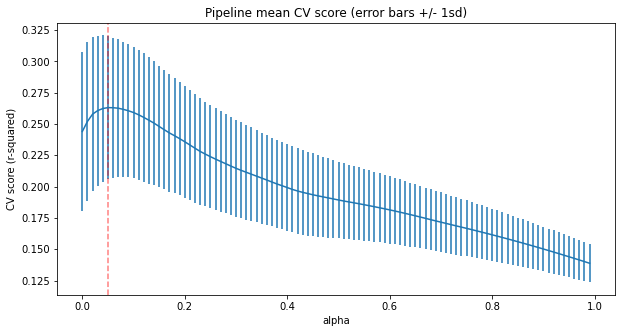

In [22]:
# plot mean CV score vs. alpha
best_lasso = lasso_cv.best_params_['lasso__alpha']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_lasso, score_mean, yerr=score_std)
plt.axvline(x=best_lasso, c='r', ls='--', alpha=.5)
plt.xlabel('alpha')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good alpha for our lasso model is 0.05.

In [23]:
# Create an improved Lasso model with alpha =0.05
best_lasso_pipe = make_pipeline(
    preprocess,
    Lasso(alpha=0.05)
)
best_lasso_pipe.fit(X_train, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Rating', 'Years Founded']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
        

In [39]:
# Assessing performance using cross-validation for prediction of y_train1: minimum salary
cv_best_lasso_min = cross_validate(best_lasso_pipe, X_train, y_train1, cv=5)['test_score']
np.mean(cv_lasso_min),np.std(cv_lasso_min)

(0.2630425713610481, 0.05703177953314068)

In [41]:
# Assessing performance using cross-validation for prediction of y_train2: maximum salary
cv_best_lasso_max = cross_validate(best_lasso_pipe, X_train, y_train2, cv=5)['test_score']
np.mean(cv_best_lasso_max), np.std(cv_best_lasso_max)

(0.25238757598838124, 0.0545247744175835)

Recall that the default lasso model gave a mean cv score of 0.137, it's obvious that choosing alpha = 0.05 has greatly improved the lasso model performance.

#### Which features were most useful? 

In [24]:
# define a function to get feature names from our pipeline
import sklearn
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Code adapted from:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

In [25]:
feature_names = get_feature_names(preprocess)

<ipython-input-24-914e3f59aa47>:33: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-24-914e3f59aa47>:33: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [26]:
lasso_coefs = best_lasso_pipe.named_steps.lasso.coef_

In [61]:
# Display the top 30 most important features selected by lasso and thier correspnding coefficients
pd.DataFrame({'coefs':lasso_coefs,'The absolute value of coefs':abs(lasso_coefs)}, 
             index=get_feature_names(preprocess)).sort_values('The absolute value of coefs',ascending=False).head(30)

<ipython-input-24-914e3f59aa47>:33: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-24-914e3f59aa47>:33: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


,coefs,The absolute value of coefs
onehotencoder__x7_IL,20.885350,20.885350
onehotencoder__x7_CA,19.458577,19.458577
onehotencoder__x7_UT,-16.180112,16.180112
onehotencoder__x7_OH,-11.761645,11.761645
onehotencoder__x7_CO,10.928651,10.928651
onehotencoder__x7_NY,8.896904,8.896904
onehotencoder__x7_NJ,7.758899,7.758899
onehotencoder__x9_Media,-7.746343,7.746343
onehotencoder__x7_IN,-7.411508,7.411508
onehotencoder__x10_$1 to $5 million (USD),3.494513,3.494513


These results suggest that Location_CA and Location_IL are our biggest positive features, and Location_UT and Location_OH are our biggest negative features.

### 4.Random Forest Model

In [42]:
# Define the pipeline for a random forest baseline model
rf_pipe = make_pipeline(
    preprocess,
    RandomForestRegressor(random_state=47)
)

In [43]:
rf_default_cv_results = cross_validate(rf_pipe, X_train, y_train1, cv=5)

In [44]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.27697319, 0.23350682, 0.22367662, 0.13702231, 0.00042933])

In [45]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.17432165442000916, 0.09808762916537621)

The test score doesn't seem good enough. Random forest has a number of hyperparameters that can be explored, so let's see how we can improve this model by tuning the hyperparameters.  
Since this data set is not large (about 2000 samples), the grid search may outperform the random search. Therefore, I'll just go straight to use GridSearchCV to search for the best hyperparameters.

#### Hyperparameter search using GridSearchCV

In [50]:
rf_param_grid = {
    'randomforestregressor__bootstrap': [True, False],
    'randomforestregressor__max_features': ['auto', 'sqrt'],
    'randomforestregressor__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 1500, num = 15)]
}
rf_param_grid

{'randomforestregressor__bootstrap': [True, False],
 'randomforestregressor__max_features': ['auto', 'sqrt'],
 'randomforestregressor__n_estimators': [10,
  116,
  222,
  329,
  435,
  542,
  648,
  755,
  861,
  967,
  1074,
  1180,
  1287,
  1393,
  1500]}

In [51]:
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)

In [52]:
rf_grid_cv.fit(X_train, y_train1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating',
                                                                          'Years '
                                                                          'Founded']),
                                                                        ('pipeline-2',
                                         

In [53]:
rf_grid_cv.best_params_

{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__n_estimators': 222}

In [54]:
# Assessing performance using cross-validation for prediction of y_train1: minimum salary
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train1, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.3170159 , 0.24479289, 0.21544035, 0.20045812, 0.09846076])

In [55]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.21523360488973156, 0.07083451644190034)

To determine if the grid search yielded a better model, we compare the best random forestgrid search model with our random forest base model.

Recall that our random forest base model gave a mean test score of 0.17432165442000916 and 0.09808762916537621 standard deciation. Comparing to the random forest base model, the grid search we've done yielded a better result.

<ipython-input-24-914e3f59aa47>:33: UserWarning: Transformer simpleimputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-24-914e3f59aa47>:33: UserWarning: Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


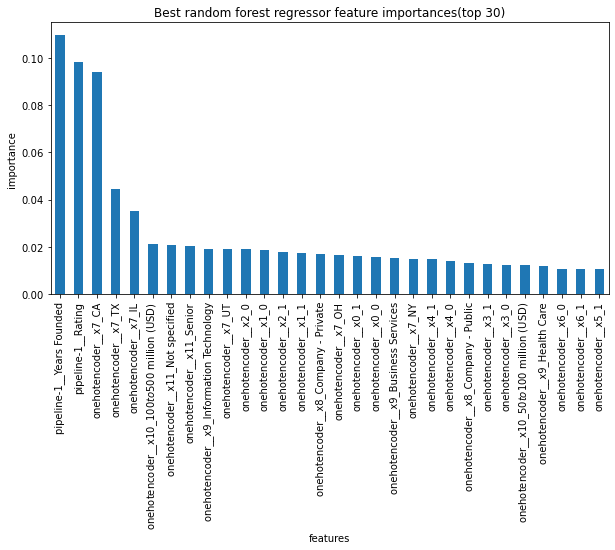

In [63]:
#Plot a barplot of the random forest's feature importances (display the top 30 most important features only)
plt.subplots(figsize=(10, 5))
importances = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(importances, index=get_feature_names(preprocess)).sort_values(ascending=False).head(30)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances (top 30)');

We can see that the dominant top five features are
- YearsFounded
- Rating
- Location_CA
- Location_TX
- Location_IL  

Both of the lasso and random forest models show that the locations CA and IL are very important features, but it's a bit strange that the features 'YearsFounded' and 'Rating' are the top two important features selected by the random forest model, while they don't seem important at all for the lasso model.